# ch04.04 Style Transfer

* 날짜: 2022-08-17
* 이름: 고민수

## 학습내용
    - Style transfer에 대해 이해하고 코드로 구현한다.
    - Stlye transfer를 사용하여 이미지의 스타일을 바꾼다.

* [논문: Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
* [Keras 실습 참고 코드](https://keras.io/examples/generative/neural_style_transfer/)

<p align='center'>
<img  src ='https://www.popit.kr/wp-content/uploads/2018/04/gatys_style_transfer.jpg' width=700>
</p>

## 이미지 전처리
---

In [14]:
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, applications, optimizers, models
import numpy as np
import matplotlib.pyplot as plt

# tf2 에서 tf1 모델을 사용해야할 때 eagerly를 설정
tf.config.run_functions_eagerly(True)

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
class ImgPreprocess():
    
    def __init__(self, combination_shape, base_model=applications.vgg19):
        self.combination_shape = combination_shape
        self.base_model = base_model
    
    # 이미지 경로 -> 전처리된 텐서 변환
    def path2tensor(self, img_path):
        img = preprocessing.image.load_img(img_path, target_size=self.combination_shape[:2])
        img = preprocessing.image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = self.base_model.preprocess_input(img)
        img = tf.convert_to_tensor(img)
        return img
        
    # (전처리 된) 텐서 -> (전처리 전) 텐서 이미지
    def tensor2img(self, tensor):
        x = tensor.numpy()
        x = x.reshape(self.combination_shape)
        # VGG 전처리 되돌리기
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype("uint8")
        return x

In [17]:
img_src = "../../Image_src/"

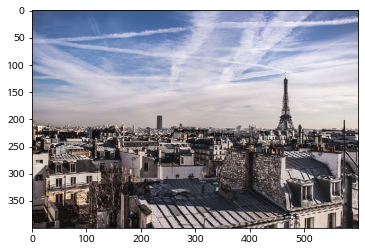

In [18]:
p = ImgPreprocess((400,600,3))
tensor = p.path2tensor(img_src+"Content_img.jpg")
img = p.tensor2img(tensor)
plt.imshow(img)

![](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

In [19]:
def display_imgs(target_img, ref_img, combination_img=None):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(target_img)
    plt.title('Target Image (for content)', fontdict={"fontsize":20})
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(ref_img)
    plt.title('Reference Img (for style)', fontdict={"fontsize":20})
    if combination_img is not None:
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(combination_img)
        plt.title('Combination Image', fontdict={"fontsize":20})
    plt.show()

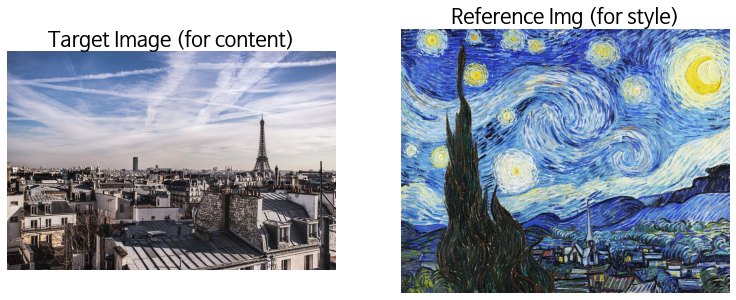

In [20]:
target_img = plt.imread(img_src+"Content_img.jpg")
ref_img = plt.imread(img_src+"Style_img.jpg")
display_imgs(target_img, ref_img)

## 모델 준비
---

<p align='center'>
<img  src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzzZ6d%2FbtqtZOLsxg8%2Fdykdt2eKeWaxRFx8iyzEE0%2Fimg.png
' width=500>
</p>


In [21]:
COMBINATION_SHAPE = (400, 600, 3)
BASE_MODEL = applications.vgg19

#### **특성 추출기**

In [22]:
model = BASE_MODEL.VGG19(input_shape=COMBINATION_SHAPE, include_top=False, weights="imagenet", )
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 150, 128)     0     

In [23]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
extractor = models.Model(inputs=model.inputs, outputs=outputs_dict)

#### **이미지 텐서 준비**

In [24]:
p = ImgPreprocess(COMBINATION_SHAPE, BASE_MODEL)
# target (content)
target_tensor = p.path2tensor(img_src+"Content_img.jpg")
# reference (style)
reference_tensor = p.path2tensor(img_src+"Style_img.jpg")
# combination
combination_tensor = tf.Variable(p.path2tensor(img_src+"Content_img.jpg"))
print(target_tensor.shape, reference_tensor.shape, combination_tensor.shape)

(1, 400, 600, 3) (1, 400, 600, 3) (1, 400, 600, 3)


#### **특성 추출**

In [25]:
inputs = tf.concat([target_tensor, reference_tensor, combination_tensor], axis=0)
print("인풋shape               \t:\t", inputs.shape)
outputs = extractor(inputs)
print("아웃풋(per layer)shape\t:\t", len(outputs))

인풋shape               	:	 (3, 400, 600, 3)
아웃풋(per layer)shape	:	 22


In [26]:
for i in extractor.layers:
    print(i.name, "\t\t\t",i.output.shape)

input_2 			 (None, 400, 600, 3)
block1_conv1 			 (None, 400, 600, 64)
block1_conv2 			 (None, 400, 600, 64)
block1_pool 			 (None, 200, 300, 64)
block2_conv1 			 (None, 200, 300, 128)
block2_conv2 			 (None, 200, 300, 128)
block2_pool 			 (None, 100, 150, 128)
block3_conv1 			 (None, 100, 150, 256)
block3_conv2 			 (None, 100, 150, 256)
block3_conv3 			 (None, 100, 150, 256)
block3_conv4 			 (None, 100, 150, 256)
block3_pool 			 (None, 50, 75, 256)
block4_conv1 			 (None, 50, 75, 512)
block4_conv2 			 (None, 50, 75, 512)
block4_conv3 			 (None, 50, 75, 512)
block4_conv4 			 (None, 50, 75, 512)
block4_pool 			 (None, 25, 37, 512)
block5_conv1 			 (None, 25, 37, 512)
block5_conv2 			 (None, 25, 37, 512)
block5_conv3 			 (None, 25, 37, 512)
block5_conv4 			 (None, 25, 37, 512)
block5_pool 			 (None, 12, 18, 512)


In [27]:
content_layer = "block5_conv2"
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

## 손실 정의
---

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FboAUdP%2Fbtqt7RHqZqN%2Fx6SxUNLAdhpBw7J5JcK08k%2Fimg.png)

### **| Content 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FclyRn2%2Fbtqt4yhBuoM%2FA6LcrtitH46HHzqYu40vo1%2Fimg.png)

#### **Content 손실 정의**

In [28]:
# 3개의 이미지에 대한 3개의 Content가 생성
# target 이미지의 content를 가져와야함
# target 과 combination의 Content Loss가 작아져야 함

def get_content_loss(target_content, combination_content):
    return 0.5* tf.reduce_sum( (tf.square( target_content - combination_content)) )

#### **Content 손실 계산**

In [29]:
# Content는 특정 layer의 아웃풋을 일컫는다.
contents = outputs[content_layer]
print(contents.shape)

target_content = contents[0]
combination_content = contents[2]
print(contents[0].shape)
print(contents[2].shape)

content_loss = get_content_loss(target_content, combination_content)
print("Content Loss\t\t:", content_loss.numpy())

(3, 25, 37, 512)
(25, 37, 512)
(25, 37, 512)
Content Loss		: 0.0


### **| 스타일 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FE2teK%2FbtqubfnwDl2%2F9WdiAMbhEKKL9SNNfQqdlk%2Fimg.png)


#### **그램(gram) 매트릭스**

In [30]:
def gram(x): # x : (h, w, ch)
    x = tf.transpose(x, (2,0,1) ) # x: (ch, h ,w)
    x = tf.reshape(x , (tf.shape(x)[0], -1) ) # x: (ch, h*w)
    x = tf.matmul(x, tf.transpose(x) )
    return x

print(contents[1].shape)
print(gram(contents[1]).shape)

(25, 37, 512)
(512, 512)


#### **스타일 손실 정의**

In [31]:
# N : Feature Map(style)의 채널 수
# M : Feature Map(style) 의 resolution(h*w)

# G : Feature Map(reference style)의 Gram Matrix
# A: Feature Map(combination style)의 Gram Matrix
def get_style_loss(reference_style, combination_style):
    N = reference_style.shape[2]
    M = reference_style.shape[0]*reference_style.shape[1]
    G = gram(reference_style)
    A = gram(combination_style)
    return tf.reduce_sum( tf.square( G-A ) ) / (4* (N**2)*(M**2) )

#### **스타일 손실 계산**

In [32]:
# Style layer로 지정해둔 곳에서 output을 받음
style_loss_list = []
for style_layer  in style_layers:
    styles = outputs[style_layer]
    print(f"{style_layer}의 shape : \t", styles.shape)
    
    # style img, combination img 의 style 값을 받음
    reference_style = styles[1]
    combination_style = styles[2]
    print(style_layer, reference_style.shape, combination_style.shape)
    
    # 스타일 손실 계산
    style_loss = get_style_loss(reference_style, combination_style)
    style_loss_list.append(style_loss)
    print("style_loss\t\t :", style_loss ,"\n")
np.mean(style_loss_list)

block1_conv1의 shape : 	 (3, 400, 600, 64)
block1_conv1 (400, 600, 64) (400, 600, 64)
style_loss		 : tf.Tensor(461636.6, shape=(), dtype=float32) 

block2_conv1의 shape : 	 (3, 200, 300, 128)
block2_conv1 (200, 300, 128) (200, 300, 128)
style_loss		 : tf.Tensor(199851620.0, shape=(), dtype=float32) 

block3_conv1의 shape : 	 (3, 100, 150, 256)
block3_conv1 (100, 150, 256) (100, 150, 256)
style_loss		 : tf.Tensor(399241820.0, shape=(), dtype=float32) 

block4_conv1의 shape : 	 (3, 50, 75, 512)
block4_conv1 (50, 75, 512) (50, 75, 512)
style_loss		 : tf.Tensor(77558930000.0, shape=(), dtype=float32) 

block5_conv1의 shape : 	 (3, 25, 37, 512)
block5_conv1 (25, 37, 512) (25, 37, 512)
style_loss		 : tf.Tensor(8328326.5, shape=(), dtype=float32) 



15633364000.0

#### **| 총 변위 손실**

* 생성된 이미지가 공간적인 연속성을 가지도록 도와준다.
* 픽셀의 격자무늬가 과도하게 나타나는 것을 막아 준다.
* 일종의 규제 항으로 해석할 수 있다.

## 학습
---

### **| 학습을 위한 정리**

In [33]:
# 손실함수 정의
def comput_loss(target_tensor, reference_tensor, combination_tensor, weights_rate=0.01):
    # 특성추출
    inputs = tf.concat([target_tensor, reference_tensor, combination_tensor], axis=0)
    outputs = extractor(inputs)
    
    # 컨텐츠 손실 - [target - combinataion]
    contents = outputs[content_layer]
    content_loss = get_content_loss(contents[0], contents[2])
    
    # 스타일 손실 - [reference - combination]
    style_loss_list = []
    for style_layer  in style_layers:
        styles = outputs[style_layer]

        # style img, combination img 의 style 값을 받음
        reference_style = styles[1]
        combination_style = styles[2]

        # 계산
        style_loss = get_style_loss(reference_style, combination_style)
        style_loss_list.append(style_loss)
    style_loss = np.mean(style_loss_list)
    
    # 최종 손실
    alpha = 0.1
    beta = alpha / weights_rate
    total_loss = alpha*content_loss + beta*style_loss
    return total_loss

comput_loss(target_tensor, reference_tensor, combination_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=156333640000.0>

In [34]:
# Gradient 정의

# tf.function 반복적으로 돌아가는 것에 효율을 높여준다
@tf.function
def comput_loss_grads(target_tensor, reference_tensor, combination_tensor, weights_rate=0.01):
    with tf.GradientTape() as tape: # gradient 계산기
        loss = comput_loss(target_tensor, reference_tensor, combination_tensor, weights_rate=0.01) # 손실함수
        
    grads = tape.gradient(loss, combination_tensor) # (손실함수, 변수)
    return loss, grads

iters = 1000
opt = optimizers.SGD(optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

In [35]:
# 이미지 준비
TARGET_SAHPE = (400, 600, 3)
p = ImgPreprocess(TARGET_SAHPE)

# path
target_path = img_src + "Content_img.jpg"
reference_path = img_src + "Style_img.jpg"

# read
target_img = plt.imread(target_path)
reference_img = plt.imread(reference_path)

# preprocess (to tensor)
target_tensor = p.path2tensor(target_path)
reference_tensor = p.path2tensor(reference_path)
# combination_tensor = tf.Variable(p.path2tensor(target_path))

### 학습

In [36]:
ters = 5000
for i in range(iters):
    loss, grads = comput_loss_grads(target_tensor,
                                     reference_tensor,
                                     combination_tensor,
                                     weights_rate=0.01)
    opt.apply_gradients([(grads, combination_tensor)])
    if i % 100 == 0:
        print(f'> iter {i}/{iters} : {loss.numpy():.4f}')

> iter 0/1000 : 156333637632.0000
> iter 100/1000 : 156333637632.0000
> iter 200/1000 : 156333637632.0000


ValueError: setting an array element with a sequence.

In [ ]:
# 결과
result = p.tensor2img(combination_tensor)
display_imgs(target_img, reference_img, result)